# Channel Charting with WiFi: Triplet Neural Network for ESPARGOS Datasets

This notebook is based on our [tutorial on timestamp/triplet-based Channel Charting](https://dichasus.inue.uni-stuttgart.de/tutorials/tutorial/channelcharting/).

However, instead of a [DICHASUS](https://dichasus.inue.uni-stuttgart.de/) dataset, we use an [ESPARGOS](https://espargos.net/) dataset called [espargos-0002](https://espargos.net/datasets/data/espargos-0002/)

In [1]:
import matplotlib.pyplot as plt
import sklearn.manifold
import sklearn.metrics
import tensorflow as tf
import numpy as np
import random

2024-08-27 09:55:22.828305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 09:55:23.766720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Configure Hyperparameters

In [2]:
# First and last time tap to consider in the measured channel impulse responses
TAP_START = 56
TAP_STOP = 69

# Number of CSI datapoints over which to average / interpolate
BACKLOGSIZE = 5

# The espargos-0002 dataset offers phase synchronization, but no time synchronization (sampling time offset).
# This parameter controls residual sampling time offset compensation.
DEFAULT_PEAK_THRESHOLD = 0.3

# Batch size for neural network training
BATCH_SIZE = 12000

# Number of training sessions
SESSIONS = 5

# Learning rate for first and final training sessions
LEARNING_RATE_INITIAL = 0.0066
LEARNING_RATE_FINAL = 5e-05

# Threshold for "close" sample for first and final training sessions
T_C_INITIAL = 5.2
T_C_FINAL = 3.3

## Load Dataset

In [3]:
raw_dataset = tf.data.TFRecordDataset(["espargos-0002/espargos-0002-all-randomwalk-3.tfrecords", "espargos-0002/espargos-0002-all-radial-meanders-1.tfrecords", "espargos-0002/espargos-0002-all-spiral-1.tfrecords"])

feature_description = {
    "csi": tf.io.FixedLenFeature([], tf.string, default_value = ''),
    "pos": tf.io.FixedLenFeature([], tf.string, default_value = ''),
    "time": tf.io.FixedLenFeature([], tf.string, default_value = ''),
    "rssi": tf.io.FixedLenFeature([], tf.string, default_value = ''),
}

def record_parse_function(proto):
    record = tf.io.parse_single_example(proto, feature_description)

    csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type = tf.complex64), (4, 2, 4, 117))
    rssi = tf.ensure_shape(tf.io.parse_tensor(record["rssi"], out_type = tf.float32), (4, 2, 4))
    pos = tf.ensure_shape(tf.io.parse_tensor(record["pos"], out_type = tf.float64), (3))

    csi = tf.signal.fftshift(csi, axes=-1)
    time = tf.ensure_shape(tf.io.parse_tensor(record["time"], out_type = tf.float64), ())

    return csi, rssi, pos, time

def shift_to_firstpeak(max_delay_taps = 4, search_resolution = 100, peak_threshold = 0.4):
    def shift(csi, rssi, pos, time):
        # Time-shift all collected CSI so that first "peak" is at time 0
        # CSI datapoints has shape (datapoints, arrays, rows, columns, subcarriers)
        shifts = tf.cast(tf.linspace(-max_delay_taps, 0, search_resolution), tf.float64)
        subcarrier_range = tf.range(-csi.shape[-1] // 2, csi.shape[-1] // 2, dtype = tf.float64) + 1
        shift_vectors = tf.math.exp(1.0j * tf.cast(tf.einsum("s,d->sd", shifts, 2 * np.pi * subcarrier_range / csi.shape[-1]), tf.complex64))
        powers_by_delay = tf.math.abs(tf.einsum("lbrms,ds->lbrmd", csi, shift_vectors))
        max_peaks = tf.math.reduce_max(powers_by_delay, axis = -1)
        first_peak = tf.math.argmax(powers_by_delay > peak_threshold * max_peaks[:,:,:,:,np.newaxis], axis = -1)
        shift_to_firstpeak = tf.gather(shift_vectors, first_peak) # shift_vectors[first_peak]
    
        return shift_to_firstpeak * csi, rssi, pos, time

    return shift

def csi_interp_iterative(iterations=10):
    def interpolate(csi, rssi, pos, time):
        phi = tf.zeros_like(csi[:,0,0,0,0], dtype = csi.dtype)
        w = None
        
        for i in range(iterations):
            w = tf.einsum("d,darmt->armt", tf.math.exp(-1.0j * phi), csi) / BACKLOGSIZE
            phi = tf.complex(tf.math.angle(tf.einsum("armt,darmt->d", tf.math.conj(w), csi)), 0.0)

        pos = tf.math.reduce_mean(pos, axis = 0)
        rssi = 10 * tf.math.log(tf.math.reduce_mean(10 ** (rssi / 10), axis = 0)) / tf.math.log(tf.constant(10.0))
        time = tf.math.reduce_mean(time)
        
        return w, rssi, pos, time

    return interpolate

def weight_csi_with_rssi(csi, rssi, pos, time):
    csi = tf.cast((10**(rssi / 20))[:,:,:,tf.newaxis], tf.complex64) * csi
    return csi, rssi, pos, time

def csi_time_domain(csi, rssi, pos, time):
    csi = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi, axes=-1)),axes=-1)

    return csi, rssi, pos, time

def cut_out_taps(start, stop):
    def cut_out_taps_func(csi, rssi, pos, time):
        return csi[...,start:stop], rssi, pos, time

    return cut_out_taps_func

dataset = raw_dataset.map(record_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BACKLOGSIZE)
dataset = dataset.map(shift_to_firstpeak(peak_threshold = DEFAULT_PEAK_THRESHOLD))
dataset = dataset.map(csi_interp_iterative())
dataset = dataset.map(weight_csi_with_rssi)
dataset = dataset.map(csi_time_domain)
dataset = dataset.map(cut_out_taps(TAP_START, TAP_STOP))

# If you have enough RAM...
dataset = dataset.cache()

2024-08-27 09:55:24.894256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 09:55:24.945831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 09:55:24.946202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Plot "Ground Truth" Positions

2024-08-27 09:56:22.694176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-27 09:56:22.930204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


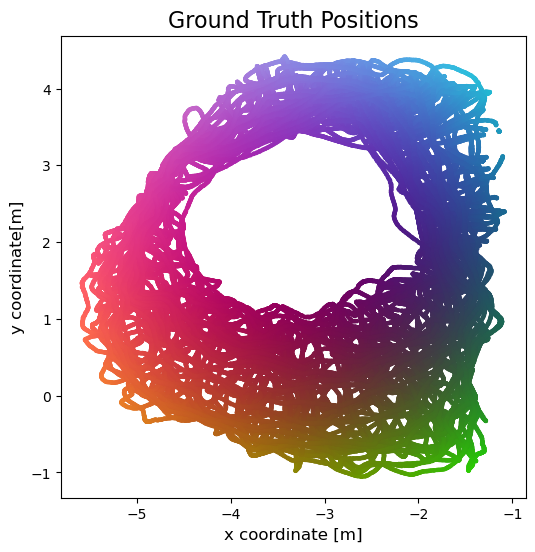

In [4]:
# This may take a long time, since TensorFlow has to load the dataset from disk!
groundtruth_positions = []
timestamp_index_map = dict()
csi_shape = None

for index, data in enumerate(dataset):
    groundtruth_positions.append(data[2].numpy()[:2])
    timestamp_index_map[data[3].numpy()] = index

timestamp_index_map = dict(sorted(timestamp_index_map.items()))
groundtruth_positions = np.asarray(groundtruth_positions)

for csi, rssi, pos, time in dataset.take(1):
    csi_shape = csi.shape

def plot_colorized(positions, title = None, xlabel = None, ylabel = None):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)

    if xlabel is not None:
        plt.xlabel(xlabel, fontsize = 12)

    if ylabel is not None:
        plt.ylabel(ylabel, fontsize = 12)
    
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, s = 5)

plot_colorized(groundtruth_positions, title="Ground Truth Positions", xlabel="x coordinate [m]", ylabel="y coordinate[m]")
plt.show()

## Triplet Selection Helpers

In [5]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = (y_pred[:, :CC_DIMENSIONALITY], y_pred[:, CC_DIMENSIONALITY : 2 * CC_DIMENSIONALITY], y_pred[:, 2 * CC_DIMENSIONALITY :])
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis = 1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis = 1)
            
    return tf.maximum(positive_dist - negative_dist + 1, 0.0)

def generate_positive_sample_lookup(Tc = 1.5):
    lookup = dict()
    suitable_set = dict()
    candidate_iterator = iter(timestamp_index_map.items())
    next_suitable = next(candidate_iterator)

    for anchor_timestamp, anchor_index in timestamp_index_map.items():
        # Add additional later suitable datapoints to suitable_set
        while next_suitable[0] - anchor_timestamp < Tc:
            suitable_set.update((next_suitable,))
            try:
                next_suitable = next(candidate_iterator)
            except StopIteration:
                break

        # Remove too early suitable datapoints from suitable_set
        outdated = []
        for timestamp in suitable_set.keys():
            if anchor_timestamp - timestamp > Tc:
                outdated.append(timestamp)
            else:
                for o in outdated:
                    del suitable_set[o]
                break

        # For every potential anchor point, store lookup table of potential positive sample indices
        lookup[anchor_index] = set(suitable_set.values())
        
        # Set of suitable positive samples must not contain anchor itself
        lookup[anchor_index].remove(anchor_index)
        lookup[anchor_index] = list(lookup[anchor_index])

    return lookup

def cplx_to_real_imag(cplx):
    return tf.stack([tf.math.real(cplx), tf.math.imag(cplx)], axis = -1)

def generate_triplets(nr_of_triplets = 1000, Tc = 1.5):
    print("Generating lookup table for positive samples")
    positive_sample_lookup = generate_positive_sample_lookup(Tc)

    # Generate list of triplet containing *indices* of datapoints in dataset
    triplet_indices = []
    anchor_indices = list(positive_sample_lookup.keys())
    
    while len(triplet_indices) < nr_of_triplets:
        anchor = anchor_indices[np.random.randint(len(anchor_indices))]
        
        # Must ensure that anchor point is not a loner and actually has some close positive samples
        if len(positive_sample_lookup[anchor]) < 1:
            continue

        positive = np.random.choice(positive_sample_lookup[anchor])
        negative = anchor_indices[np.random.randint(len(anchor_indices))]
        
        triplet_indices.append((anchor, positive, negative))

    # Iterate over dataset (on hard drive storage) and load relevant CSI data to "triplets" list (in RAM)
    datapoints_to_load = dict()
    for target, indices in enumerate(triplet_indices):
        for sample in range(3):
            if indices[sample] not in datapoints_to_load:
                datapoints_to_load[indices[sample]] = []
            datapoints_to_load[indices[sample]].append((target, sample))

    datapoints_to_load = dict(sorted(datapoints_to_load.items()))

    anchors = [None for i in range(len(triplet_indices))]
    positives = [None for i in range(len(triplet_indices))]
    negatives = [None for i in range(len(triplet_indices))]

    print("Loading batch of triplets from dataset (on disk or in RAM)")
    for index, data in enumerate(dataset):
        if index in datapoints_to_load:
            for target in datapoints_to_load[index]:
                if target[1] == 0:
                    anchors[target[0]] = data[0]
                elif target[1] == 1:
                    positives[target[0]] = data[0]
                elif target[1] == 2:
                    negatives[target[0]] = data[0]
    print("Finished loading triplet batch")

    return [cplx_to_real_imag(tf.stack(anchors)), cplx_to_real_imag(tf.stack(positives)), cplx_to_real_imag(tf.stack(negatives))]

## Neural Network Definition

In [6]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.float32)

    def call(self, csi):
        # Compute sample correlations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        csi = tf.complex(csi[...,0], csi[...,1])
        sample_autocorrelations = tf.einsum("darmt,dbsnt->dtabrsmn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

CC_DIMENSIONALITY = 2
embedding_model = tf.keras.models.Sequential(
    [
        FeatureEngineeringLayer(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(CC_DIMENSIONALITY, activation = "linear"),
    ]
)

input_anchor = tf.keras.layers.Input(shape=csi_shape + (2,))
input_positive = tf.keras.layers.Input(shape=csi_shape + (2,))
input_negative = tf.keras.layers.Input(shape=csi_shape + (2,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
model = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)

## Neural Network Training

Generating lookup table for positive samples
Loading batch of triplets from dataset (on disk or in RAM)


2024-08-27 09:56:51.669933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished loading triplet batch
Training Session 1 with learning rate 0.0066 and T_c = 5.2
Epoch 1/10


I0000 00:00:1724752633.286985     182 service.cc:145] XLA service 0x7f6ac4406c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724752633.287136     182 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-08-27 09:57:13.511602: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 09:57:13.955148: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-08-27 09:57:15.935126: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:34 8s/step - loss: 1.8929

I0000 00:00:1724752637.233440     182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - loss: 0.9211
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.1822
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.1592
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.1466
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.1332
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.1236
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.1167
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.1097
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.1053
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1032
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━

2024-08-27 09:57:48.492915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


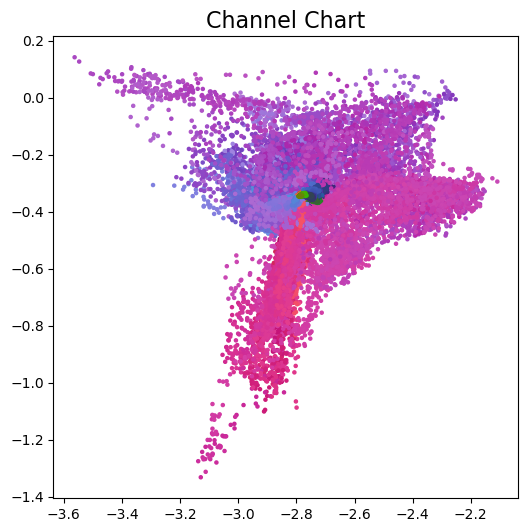

Generating lookup table for positive samples
Loading batch of triplets from dataset (on disk or in RAM)


2024-08-27 09:58:14.347376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished loading triplet batch
Training Session 2 with learning rate 0.002485588032904796 and T_c = 4.725
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.1096
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.1002
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0969
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0909
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0875
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0836
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0811
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0766
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0741
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0717
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━

2024-08-27 09:58:46.559441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


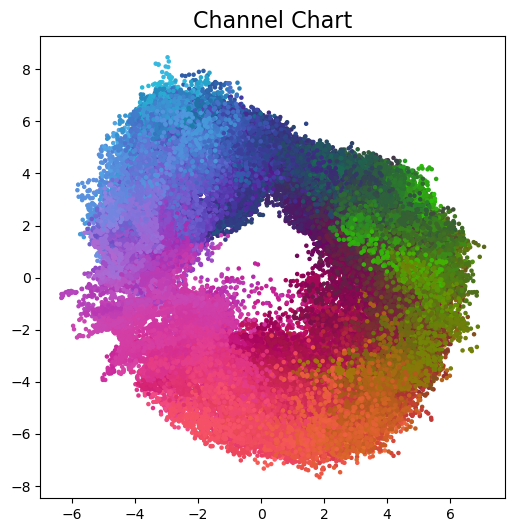

Generating lookup table for positive samples
Loading batch of triplets from dataset (on disk or in RAM)


2024-08-27 09:59:13.235968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished loading triplet batch
Training Session 3 with learning rate 0.0009360830105029595 and T_c = 4.25
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0903
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0857
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0798
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0781
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0747
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0711
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0699
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0668
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0651
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0621
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━

2024-08-27 09:59:46.332226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


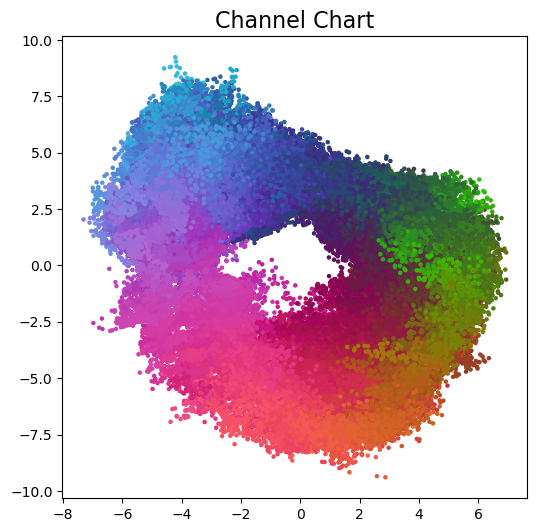

Generating lookup table for positive samples
Loading batch of triplets from dataset (on disk or in RAM)


2024-08-27 10:00:13.335317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished loading triplet batch
Training Session 4 with learning rate 0.00035253283768358343 and T_c = 3.775
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0758
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0723
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0693
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0687
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0647
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0645
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0625
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0613
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0598
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0594
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
313/313 ━━

2024-08-27 10:00:45.719281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


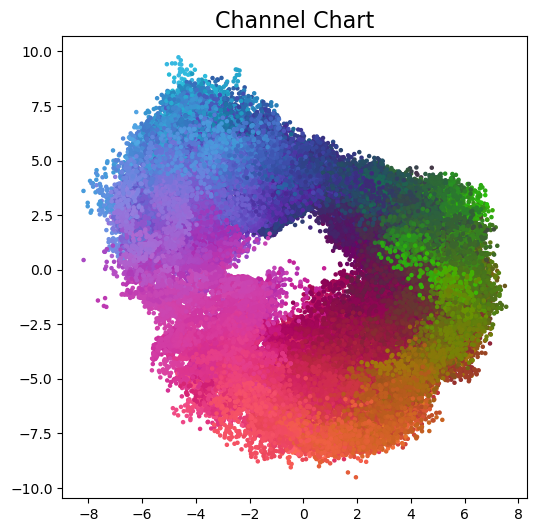

Generating lookup table for positive samples
Loading batch of triplets from dataset (on disk or in RAM)


2024-08-27 10:01:11.897958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished loading triplet batch
Training Session 5 with learning rate 0.00013276536402307332 and T_c = 3.3
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0627
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0616
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0609
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0597
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0582
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0573
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0560
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0551
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0550
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0541
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
313/313 ━━━━

2024-08-27 10:01:45.037661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


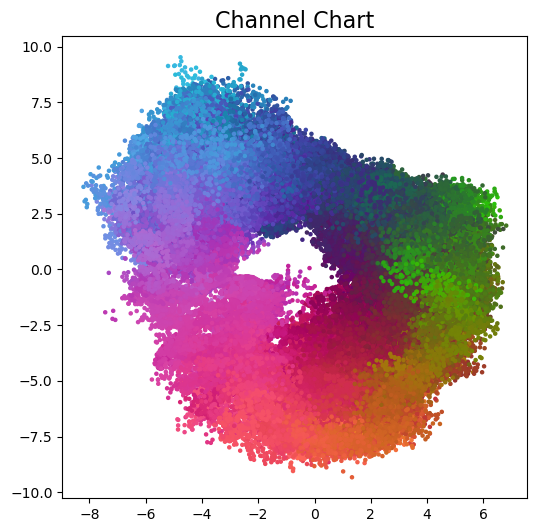

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


2024-08-27 10:01:51.766726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


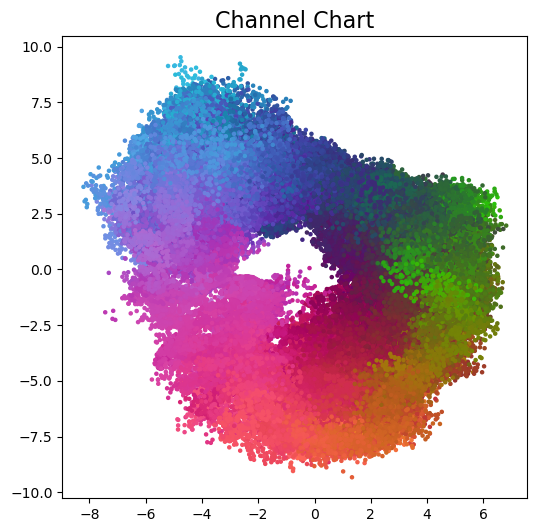

In [7]:
def plot_channel_chart():
    channel_chart_positions = []
        
    for csi, rssi, pos, timestamp in dataset.batch(10000):
        csi_real_imag = cplx_to_real_imag(csi)
        channel_chart_positions.append(embedding_model.predict(csi_real_imag))
    
    channel_chart_positions = np.vstack(channel_chart_positions)
    
    plot_colorized(channel_chart_positions, title = "Channel Chart")
    plt.show()

    return channel_chart_positions

optimizer = tf.keras.optimizers.Adam()
model.compile(loss = triplet_loss, optimizer = optimizer)

decay = (LEARNING_RATE_FINAL / LEARNING_RATE_INITIAL) ** (1 / SESSIONS)
learning_rates = LEARNING_RATE_INITIAL * decay**np.arange(SESSIONS)
T_c = T_C_INITIAL + np.arange(SESSIONS) / (SESSIONS - 1) * (T_C_FINAL - T_C_INITIAL)

for l in range(len(learning_rates)):
    triplets = generate_triplets(150000, T_c[l])
    print(f"Training Session {l+1} with learning rate {learning_rates[l]} and T_c = {T_c[l]}")
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(triplets, triplets, batch_size = BATCH_SIZE, epochs = 10)
    plot_channel_chart()

channel_chart_positions = plot_channel_chart()
plt.show()

## Evaluation: Continuity, Trustworthiness, Kruskal's Stress

In [8]:
# Continuity is identical to trustworthiness, except that original space and embedding space are swapped
def continuity(*args, **kwargs):
    args = list(args)
    args[0], args[1] = args[1], args[0]
    return sklearn.manifold.trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded, *, metric="euclidean"):
    dist_X = sklearn.metrics.pairwise_distances(X, metric = metric)
    dist_X_embedded = sklearn.metrics.pairwise_distances(X_embedded, metric = metric)
    beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

    return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

subset_indices = random.sample(range(len(groundtruth_positions)), len(groundtruth_positions) // 10)

groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]

ct_train = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw_train = sklearn.manifold.trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks_train = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

metrics_channel_chart_train = np.around(np.array([ct_train, tw_train, ks_train]), 4)

print("CT: {} \nTW: {} \nKS: {}".format(*metrics_channel_chart_train))

CT: 0.9634 
TW: 0.9626 
KS: 0.2034


## Evaluation: Localization Error after Optimal Affine Transform

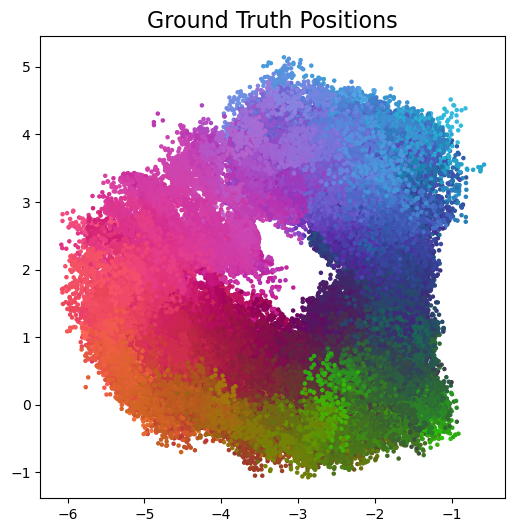

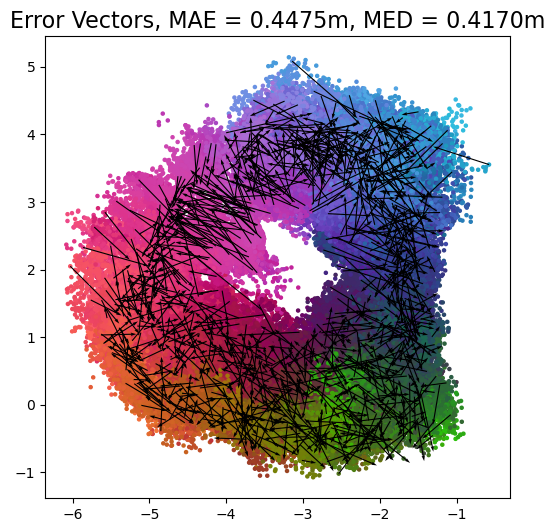

In [9]:
def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

channel_chart_positions_transformed = affine_transform_channel_chart(groundtruth_positions, channel_chart_positions)
plot_colorized(channel_chart_positions_transformed, title = "Ground Truth Positions")

errorvectors = groundtruth_positions - channel_chart_positions_transformed
errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.mean(errors)
med = np.median(errors)

nth_errorvector = 100
plot_colorized(channel_chart_positions_transformed, title = f"Error Vectors, MAE = {mae:.4f}m, MED = {med:.4f}m")
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()

## Conclusion

* Where classical model-based localization approaches (triangulation, multilateration) are not applicable, Channel Charting can at least provide an approximate location estimate.
* For absolute localization, we "cheated" here by assuming the optimal affine transform between Channel Chart and physical coordinates is known. However, there are several techniques for achieving Channel Charting in absolute global coordinates, for example the [augmented Channel Charting](https://arxiv.org/abs/2312.01968) that is also used in the `SiameseNeuralNetwork.ipynb` notebook, so this assumption is not unrealistic. Usually, applying augmented Channel Charting will even improve performance beyond just knowing the optimal affine transformation.
* The achieved mean absolute error of 0.4m is not great for the relatively small measurement area, but certainly not bad either. There is room for improvement in the future, e.g., by switching to a Siamese Neural Network-based approach, which tends to perform better if suitable dissimilarity metrics are used.